In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix

from lightgbm import LGBMClassifier

In [2]:
rc = {
    "axes.facecolor": "#F6F6F6",
    "figure.facecolor": "#F6F6F6",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

warnings.filterwarnings(action = 'ignore')

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

# Description of Key Features in the Patient Dataset 💭

**ID: Patient identifier (int)**

> This is a unique identifier assigned to each patient in the dataset. It helps distinguish one patient from another.


**Age: Age of the patient (in years)** 

> This feature indicates the age of the patient at the time of data collection. It is measured in years.
Schooling: Time the patient spent in school (in years)

**Schooling: represents the number of years the patient has spent in formal education.**

**Gender: 1=male, 2=female**
> This feature indicates the gender of the patient. A value of 1 represents male, and a value of 2 represents female.

**Breastfeeding: 1=yes, 2=no, 3=unknown**

> Breastfeeding indicates whether the patient was breastfed or not during infancy. A value of 1 represents yes, 2 represents no, and 3 represents unknown.

**Varicella: 1=positive, 2=negative, 3=unknown**

> Varicella refers to the presence or absence of a positive diagnosis for varicella, commonly known as chickenpox. A value of 1 represents a positive diagnosis, 2 represents a negative diagnosis, and 3 
represents unknown or undisclosed information.

**Initial_Symptoms: Represents the initial symptoms experienced by the patient**

> This feature describes the initial symptoms experienced by the patient. It has multiple values ranging from 1 to 15, each representing a different combination of symptoms. For example, a value of 1 corresponds to visual symptoms, 2 represents sensory symptoms, 3 represents motor symptoms, and so on.

**Mono_or_Polysymptomatic: 1=monosymptomatic, 2=polysymptomatic, 3=unknown**

> This feature categorizes patients based on whether they experienced monosymptomatic or polysymptomatic presentation of symptoms. A value of 1 indicates monosymptomatic, 2 indicates polysymptomatic, and 3 represents unknown.

**Oligoclonal_Bands: 0=negative, 1=positive, 2=unknown**

> Oligoclonal bands are abnormal bands of immunoglobulins found in the cerebrospinal fluid (CSF) that may indicate inflammation in the central nervous system. This feature indicates the presence or absence of oligoclonal bands. A value of 0 represents negative, 1 represents positive, and 2 represents unknown.

**LLSSEP: 0=negative, 1=positive**

>LLSSEP stands for Long Latency Somatosensory Evoked Potentials, which are electrical responses generated by the nervous system to a sensory stimulus. This feature indicates the presence or absence of positive LLSSEP results. A value of 0 represents negative, and 1 represents positive.

**ULSSEP: 0=negative, 1=positive**

>ULSSEP stands for Ultra-long Latency Somatosensory Evoked Potentials. Similar to LLSSEP, this feature indicates the presence or absence of positive ULSSEP results. A value of 0 represents negative, and 1 represents positive.

**VEP: 0=negative, 1=positive**

>VEP refers to Visual Evoked Potentials, which measure the electrical activity generated by the visual pathway in response to visual stimuli. This feature indicates the presence or absence of positive VEP results. A value of 0 represents negative, and 1 represents positive.

**BAEP: 0=negative, 1=positive**

>BAEP stands for Brainstem Auditory Evoked Potentials, which measure the electrical responses of the auditory system to sound stimuli. This feature indicates the presence or absence of positive BAEP results. A value of 0 represents negative, and 1 represents positive.

**Periventricular_MRI: 0=negative, 1=positive**

>Periventricular MRI refers to the presence or absence of abnormal findings in the periventricular region of the brain as observed in magnetic resonance imaging (MRI). A value of 0 represents negative, and 1 represents positive.

**Cortical_MRI: 0=negative, 1=positive**

>Cortical MRI refers to the presence or absence of abnormal findings in the cortical region of the brain as observed in MRI. A value of 0 represents negative, and 1 represents positive.

**Infratentorial_MRI: 0=negative, 1=positive**

> Infratentorial MRI refers to the presence or absence of abnormal findings in the infratentorial region of the brain as observed in MRI. A value of 0 represents negative, and 1 represents positive.

**Spinal_Cord_MRI: 0=negative, 1=positive**

> Spinal Cord MRI refers to the presence or absence of abnormal findings in the spinal cord as observed in MRI. A value of 0 represents negative, and 1 represents positive.

**initial_EDSS: ?**

>The initial EDSS (Expanded Disability Status Scale) is a measure used to assess the disability status of patients with multiple sclerosis (MS) and other related conditions. The value for this feature is missing and needs to be provided.

**final_EDSS: ?**
>The final EDSS is the EDSS score obtained after a certain period or at the end of the study. Like the initial EDSS, the value for this feature is missing and needs to be provided.

**Group: 1=CDMS, 2=non-CDMS**

**This feature categorizes patients into two groups: CDMS (Clinically Definite Multiple Sclerosis) and non-CDMS. CDMS refers to patients who meet specific diagnostic criteria for multiple sclerosis, while non-CDMS refers to patients who do not meet those criteria. A value of 1 represents CDMS, and 2 represents non-CDMS.**

In [3]:
data = pd.read_csv('/kaggle/input/conversion-predictors-of-cis-to-multiple-sclerosis/conversion_predictors_of_clinically_isolated_syndrome_to_multiple_sclerosis.csv')

In [4]:
df = data.copy()
df = df.drop('Unnamed: 0',axis = 1) 
df.head()

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,Initial_EDSS,Final_EDSS,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1.0,1.0,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,2.0,2.0,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1.0,1.0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1.0,1.0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1.0,1.0,1


In [5]:
def summarize(data):
    
    result = pd.DataFrame()

    result['Count'] = data.count()
    result['Nunique'] = data.nunique().values
    result['Missing value'] = data.isna().sum().values
    result['Freq Value'] = data.mode().iloc[0]
    result['Min'] = data.describe().T['min']
    result['Max'] = data.describe().T['max']
    result['Mean'] = data.describe().T['mean']
    result['Median'] = data.describe().T['50%']

    return result

In [6]:
summarize(df)

,Count,Nunique,Missing value,Freq Value,Min,Max,Mean,Median
Gender,273,2,0,2.0,1.0,2.0,1.615385,2.0
Age,273,48,0,28.0,15.0,77.0,34.062271,33.0
Schooling,272,12,1,20.0,0.0,25.0,15.176471,15.0
Breastfeeding,273,3,0,1.0,1.0,3.0,1.831502,2.0
Varicella,273,3,0,1.0,1.0,3.0,1.710623,2.0
Initial_Symptom,272,15,1,8.0,1.0,15.0,6.430147,6.0
Mono_or_Polysymptomatic,273,3,0,2.0,1.0,3.0,1.725275,2.0
Oligoclonal_Bands,273,3,0,0.0,0.0,2.0,0.358974,0.0
LLSSEP,273,2,0,0.0,0.0,1.0,0.424908,0.0
ULSSEP,273,2,0,0.0,0.0,1.0,0.369963,0.0


# Imputing Missing Values ⏳

In [7]:
num_data = len(df)

missing_value = round(df.isna().sum() / num_data * 100,2)

missing_df = pd.DataFrame(missing_value[missing_value.values > 0],
            columns = ['missing percent'])

missing_df

,missing percent
Schooling,0.37
Initial_Symptom,0.37
Initial_EDSS,54.21
Final_EDSS,54.21


> **If the proportion of missing values exceeds 50%, we can use machine learning techniques to impute the missing values. For cases with a low proportion of missing values, we can fill them with the mode (most frequent value).**

In [8]:
missing_cols = ['Schooling', 'Initial_Symptom']

for col in missing_cols:
    
    mode_value = df[col].value_counts().index[0]
    mode_count = df[col].value_counts().values[0]

    print('\n')
    print(f'{blk}The mode value of the {blu}{col}{blk} is {red}{mode_value}')
    print(f'{blk}The Number of mode value of the {blu}{col}{blk} is {red}{mode_count}')
    
    df[col] = df[col].fillna(mode_value) # Imputation Missing Value



The mode value of the Schooling is 20.0
The Number of mode value of the Schooling is 83


The mode value of the Initial_Symptom is 8.0
The Number of mode value of the Initial_Symptom is 39


### LGBM (Light Gradient Boosting Machine) is effective in handling missing values for the following reasons

> LGBM (Light Gradient Boosting Machine) is effective in handling missing values for the following reasons:
> 
> Tree-based algorithm: LGBM is a tree-based boosting algorithm. Tree models offer flexibility in handling missing values. They can create new branches using features with missing values and make decisions based on non-missing data to predict the missing values.
> 
> Implicit handling of missing values: LGBM can handle missing values implicitly during the tree-building process. It learns to partition data based on available features without explicitly imputing missing values. This can be advantageous as it avoids potential biases introduced by imputation methods.
> 
> Optimal splits with missing values: LGBM can find optimal split points even when features have missing values. It considers missing values as a separate category during the split selection process, allowing the algorithm to capture valuable information from missing values.
> 
> Fast and efficient training: LGBM is known for its fast training speed and efficiency. It can handle large datasets with missing values more efficiently than other algorithms. This makes it suitable for real-world applications where computational resources and time are limited.
> 
> Robustness to missingness patterns: LGBM can handle missing values irrespective of their patterns, whether they are missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR). It can effectively learn from the available data and make accurate predictions even with varying missingness patterns.
> 
> Overall, LGBM's ability to handle missing values implicitly, along with its tree-based nature and efficiency, makes it a good choice for handling missing data in various machine learning tasks.

Initial_EDSS KFOLD Start
0 FOLD accuracy : 0.8
1 FOLD accuracy : 0.8
2 FOLD accuracy : 0.88
3 FOLD accuracy : 0.76
4 FOLD accuracy : 0.84
Initial_EDSS KFOLD End 
 
Final_EDSS KFOLD Start
0 FOLD accuracy : 0.8
1 FOLD accuracy : 0.76
2 FOLD accuracy : 0.84
3 FOLD accuracy : 0.76
4 FOLD accuracy : 0.8
Final_EDSS KFOLD End 
 


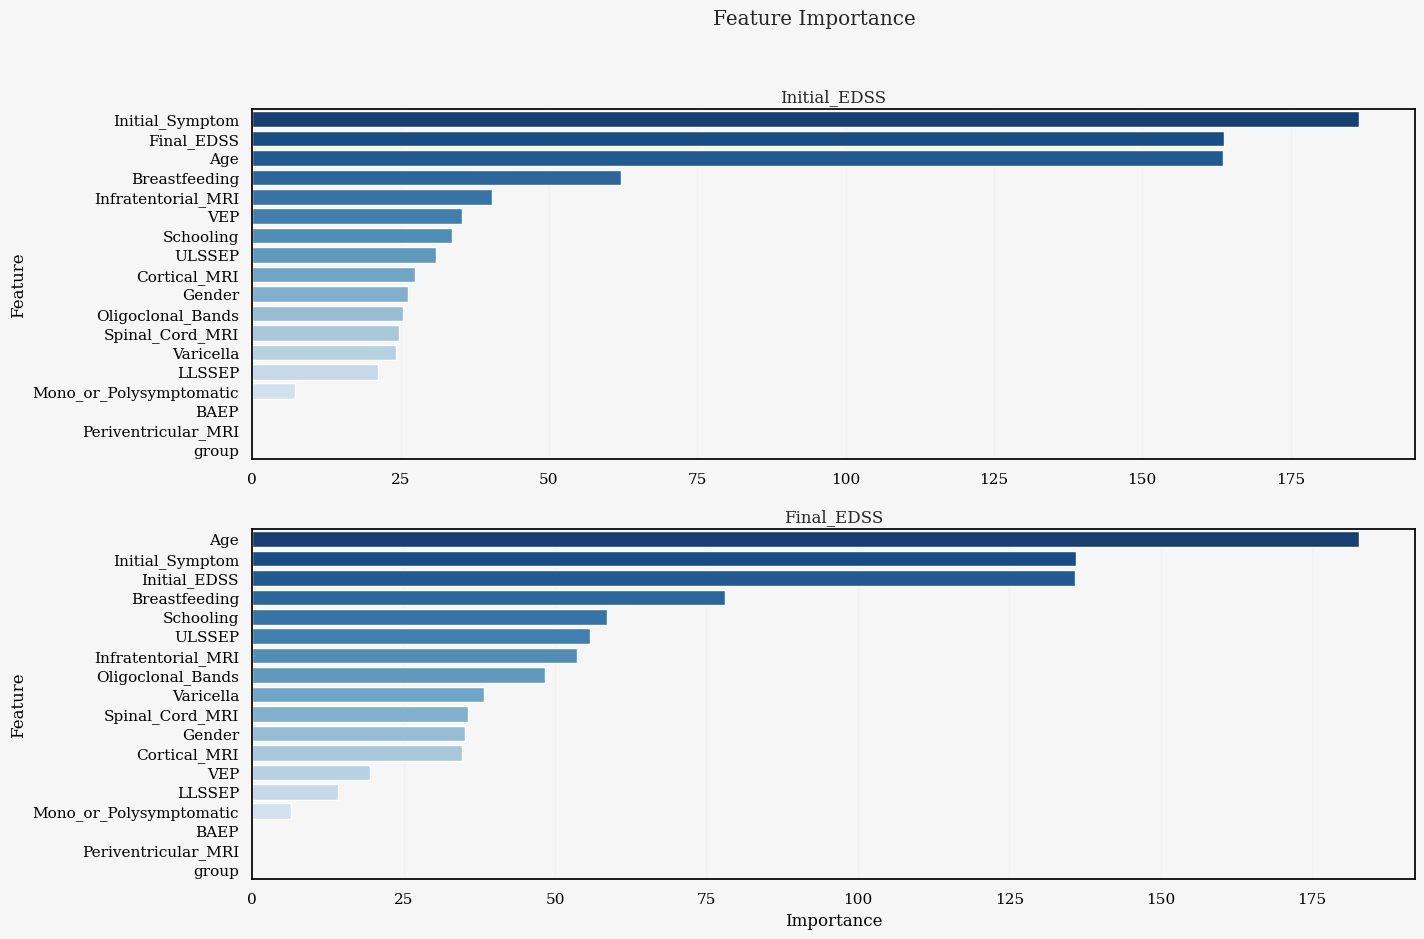

In [9]:
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': -1,
    'objective': 'binary',
    'random_state': 42,
}


missing_cols = ['Initial_EDSS','Final_EDSS'] # Missing values to be filled using machine 
split = 5
cv = KFold(n_splits = split, shuffle = True, random_state = 42)

fig,ax = plt.subplots(nrows = 2, figsize = (15,10))
for num,col in enumerate(missing_cols):
    
    cond = df[col].isna()

    missing_idx = df[cond].index

    train = df[~cond]  # Train and validation set required for training
    test = df[cond].drop(col, axis=1)  # Actual missing values to be filled later

    X = train.drop(col, axis=1)
    y = train[col]

    avg_score = 0  # Average accuracy score among 5-fold cross-validation
    feature_importance = [np.zeros(X.shape[1]) for _ in range(split)]  # Average feature importance among 5-fold cross-validation
    oof_test = [np.zeros(len(test)) for _ in range(split)]  # missing values obtained from 5-fold cross-validation

    print(f'{blk}{col} KFOLD Start{res}')
    
    for i,(train_idx,test_idx) in enumerate(cv.split(X,y)):
        
        x_train,y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test,y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        model = LGBMClassifier(**params, verbose = -1)
        
        model.fit(x_train,y_train)
        
        pred = model.predict(x_test)
        score = accuracy_score(y_test, pred)
        
        print(f'{blu}{i} FOLD accuracy : {red}{score}')
        
        avg_score +=  score / split
        feature_importance[i] += model.feature_importances_ / split
        # Probabilities of actual missing values generated during 5-fold cross-validation
        
        oof_test[i] += model.predict(test)
    
    print(f'{blk}{col} KFOLD End{res} \n ')
    # Imputation Missing value 
    
    final_result = [round(_) for _ in np.mean(oof_test,axis = 0)]
    
    df.loc[missing_idx, col] = final_result
    
    # Visualized Feature Importance 
    importance_df = pd.DataFrame({'Feature': X.columns,
                                 'Importance':np.sum(feature_importance, axis = 0)})
    
    importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
    
    sns.barplot(data = importance_df,
               x = 'Importance',
               y = 'Feature',
               palette = 'Blues_r',
               ax = ax[num])
    
    ax[num].set_title(col)
    ax[0].set_xlabel('')
    
fig.suptitle('Feature Importance');

In [10]:
df.isna().sum()

Gender                     0
Age                        0
Schooling                  0
Breastfeeding              0
Varicella                  0
Initial_Symptom            0
Mono_or_Polysymptomatic    0
Oligoclonal_Bands          0
LLSSEP                     0
ULSSEP                     0
VEP                        0
BAEP                       0
Periventricular_MRI        0
Cortical_MRI               0
Infratentorial_MRI         0
Spinal_Cord_MRI            0
Initial_EDSS               0
Final_EDSS                 0
group                      0
dtype: int64

# EDA

In [11]:
num_cols = ['Age','Schooling']

obj_cols = ['Gender','Breastfeeding', 'Varicella',
       'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands',
       'LLSSEP', 'ULSSEP', 'VEP', 'BAEP', 'Periventricular_MRI',
       'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI', 'Initial_EDSS',
       'Final_EDSS']

### Numeric Columns EDA

Text(0.5, 0.98, 'Numeric Column')

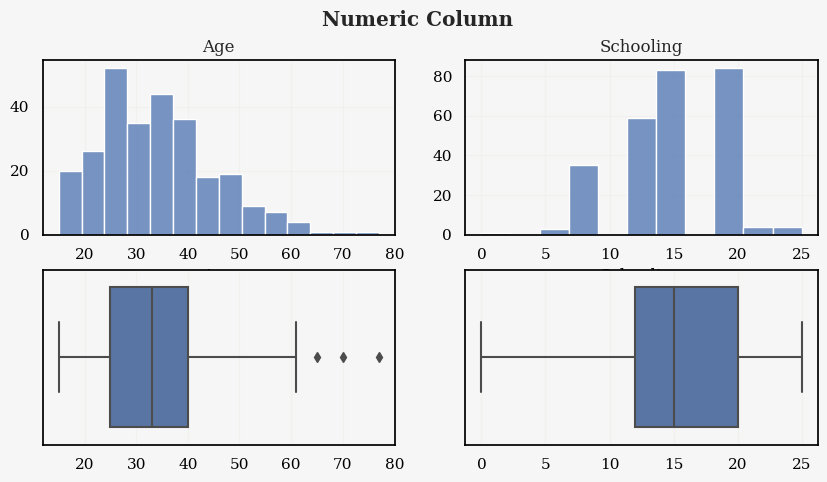

In [12]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,5))

ax = ax.flatten()

hist_idx = 0
box_idx = 2

for col in num_cols:
    
    sns.histplot(data = df,
                x = col,
                ax = ax[hist_idx])
    sns.boxplot(data = df,
                x = col,
               ax = ax[box_idx])
    
    ax[hist_idx].set_ylabel('')
    ax[box_idx].set_xlabel('')
    
    hist_idx += 1
    box_idx += 1
    
ax[0].set_title('Age')
ax[1].set_title('Schooling')
    
fig.suptitle('Numeric Column',weight = 'bold')

### Objective Columns EDA

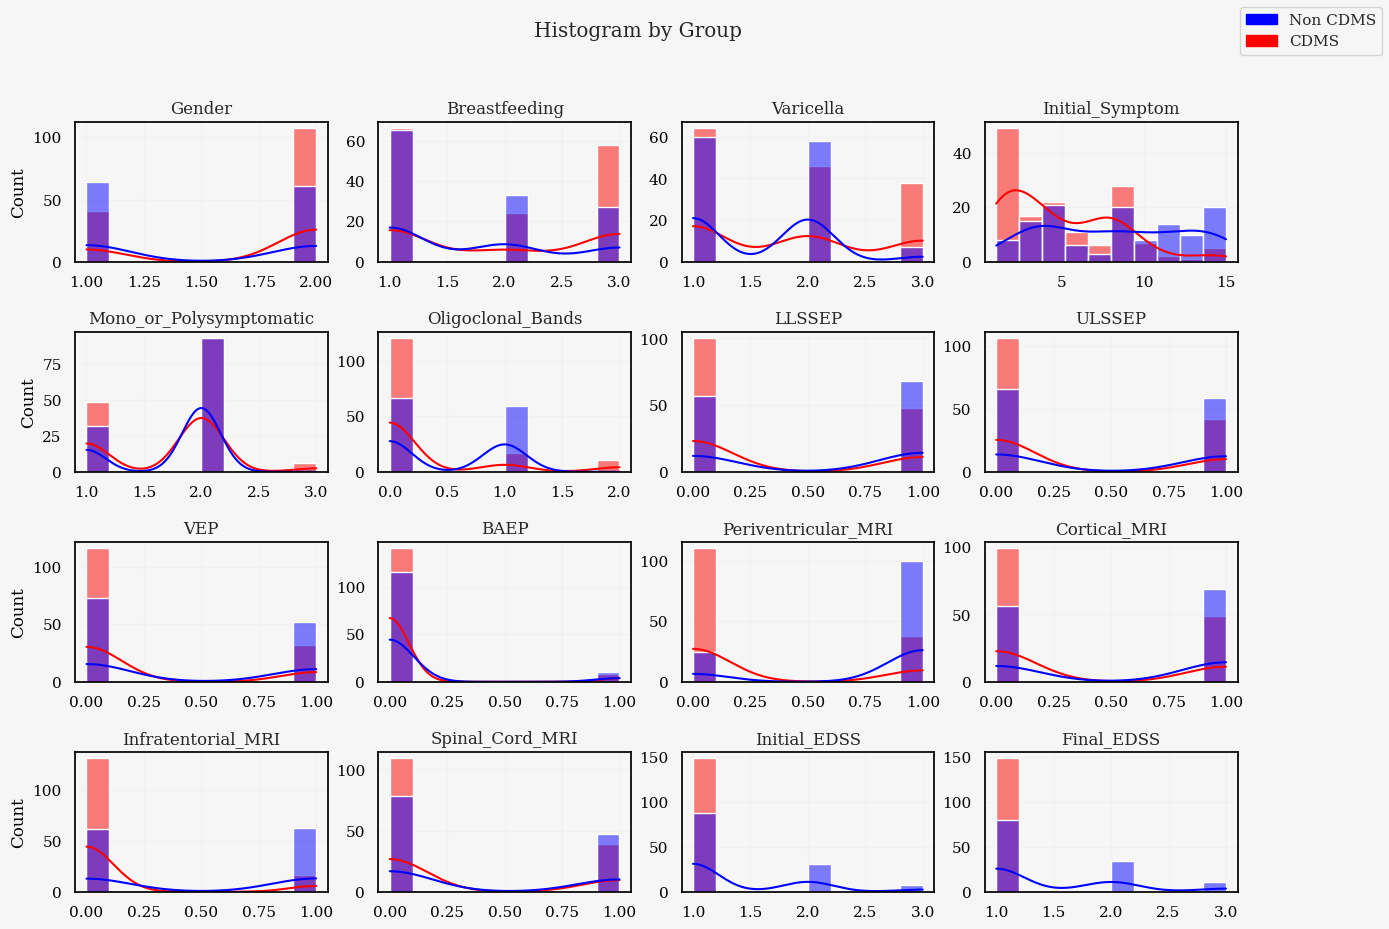

In [13]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 10))
ax = ax.flatten()

fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(obj_cols):
    sns.histplot(data=df, x=col, 
                 alpha=0.5,
                 hue= 'group', 
                 hue_order = [1,2],
                 palette=['blue', 'red'],
                 kde = True,
                 ax=ax[i], legend=None)
    
    if i % 4 != 0:
        ax[i].set_ylabel('')
    ax[i].set_title(col)
    ax[i].set_xlabel('')

blue_patch = plt.Rectangle((0, 0), 1, 1, color='blue', label='Non CDMS')
red_patch = plt.Rectangle((0, 0), 1, 1, color='red', label='CDMS')

fig.suptitle('Histogram by Group')
fig.legend(handles=[blue_patch, red_patch], loc='upper right')

# Modeling

In [14]:
X = df.drop('group',axis = 1)
y = df['group']

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

### Hyperparameter tunning

In [15]:
param_grid = {
    'num_leaves': [10,30],
    'learning_rate': [0.1,0.01],
    'max_depth': [-1, 5, 10],
    'objective': ['binary'],
    'random_state': [42],
}

cv = KFold(n_splits = 5, random_state = 42, shuffle = True)

lgbm = LGBMClassifier(verbose = -1)

grid_search = GridSearchCV(estimator=lgbm, param_grid = param_grid, cv = cv)
grid_search.fit(x_train, y_train)

print(f'{blu}Best Parameters:, {red}{grid_search.best_params_}')
print(f'{blu}Best Score: {red}{grid_search.best_score_}')

Best Parameters:, {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 10, 'objective': 'binary', 'random_state': 42}
Best Score: 0.8159619450317125


# Submission & Evaluation

In [16]:
final_model = grid_search.best_estimator_

final_model

LGBMClassifier(num_leaves=10, objective='binary', random_state=42, verbose=-1)

In [17]:
final_model.fit(x_train,y_train)

pred = final_model.predict(x_test)

score = round(accuracy_score(y_test, pred),2)

print(f'{blu}accuracy_score : {red}{score}')

accuracy_score : 0.82


Text(0.5, 1.0, 'Confusion Matrix')

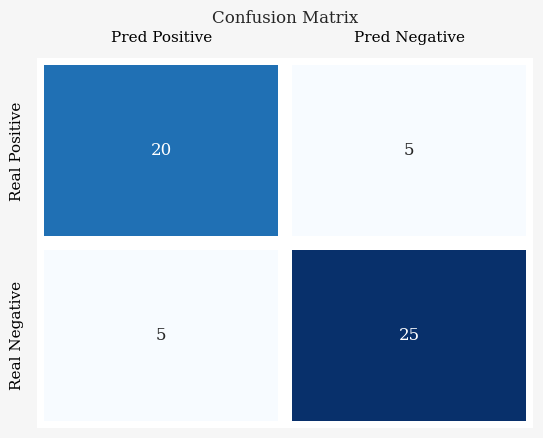

In [18]:
conf = pd.DataFrame(confusion_matrix(y_test,pred),
            index = ['Real Positive','Real Negative'],
            columns = ['Pred Positive','Pred Negative'])

fig,ax = plt.subplots()

sns.heatmap(conf, linewidth = 10, cmap = 'Blues',
            cbar = False, annot = True, ax = ax)
ax.tick_params(axis='x', labeltop=True, labelbottom=False)
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Feature Importance')

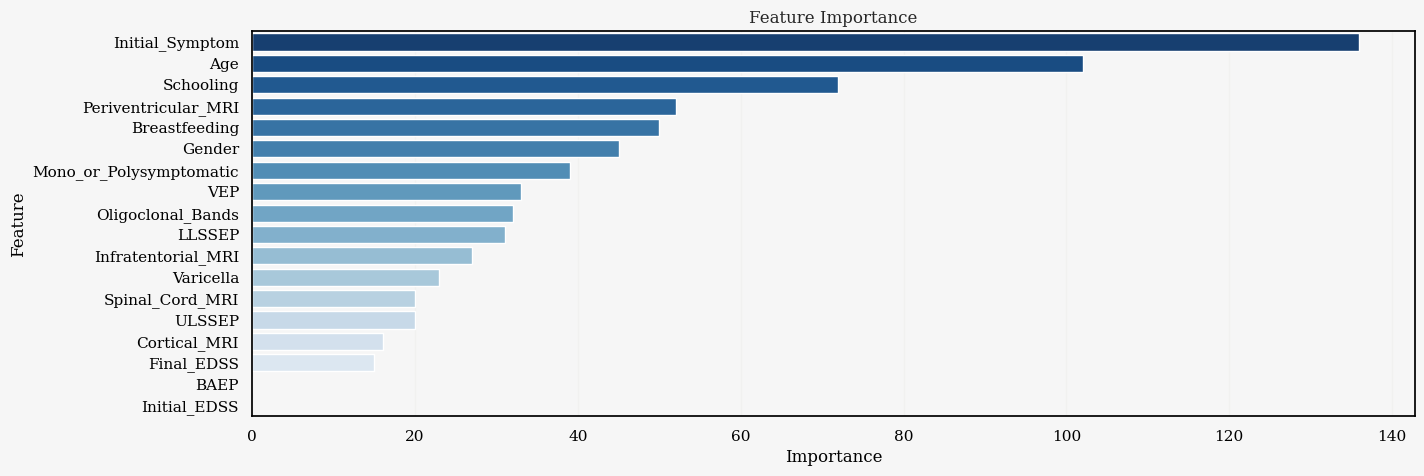

In [19]:
importance = final_model.feature_importances_

fi_df = pd.DataFrame({'Feature': x_train.columns,
             'Importance':importance}).sort_values(by = 'Importance',
                                                  ascending = False)

fig,ax = plt.subplots(figsize = (15,5))

sns.barplot(data = fi_df,
           x = 'Importance',
           y = 'Feature',
           palette = 'Blues_r',
           ax = ax)
ax.set_title('Feature Importance')

# Thx :) 